# PNEUMONIA DETECTION USING CHEST X-RAY IMAGES

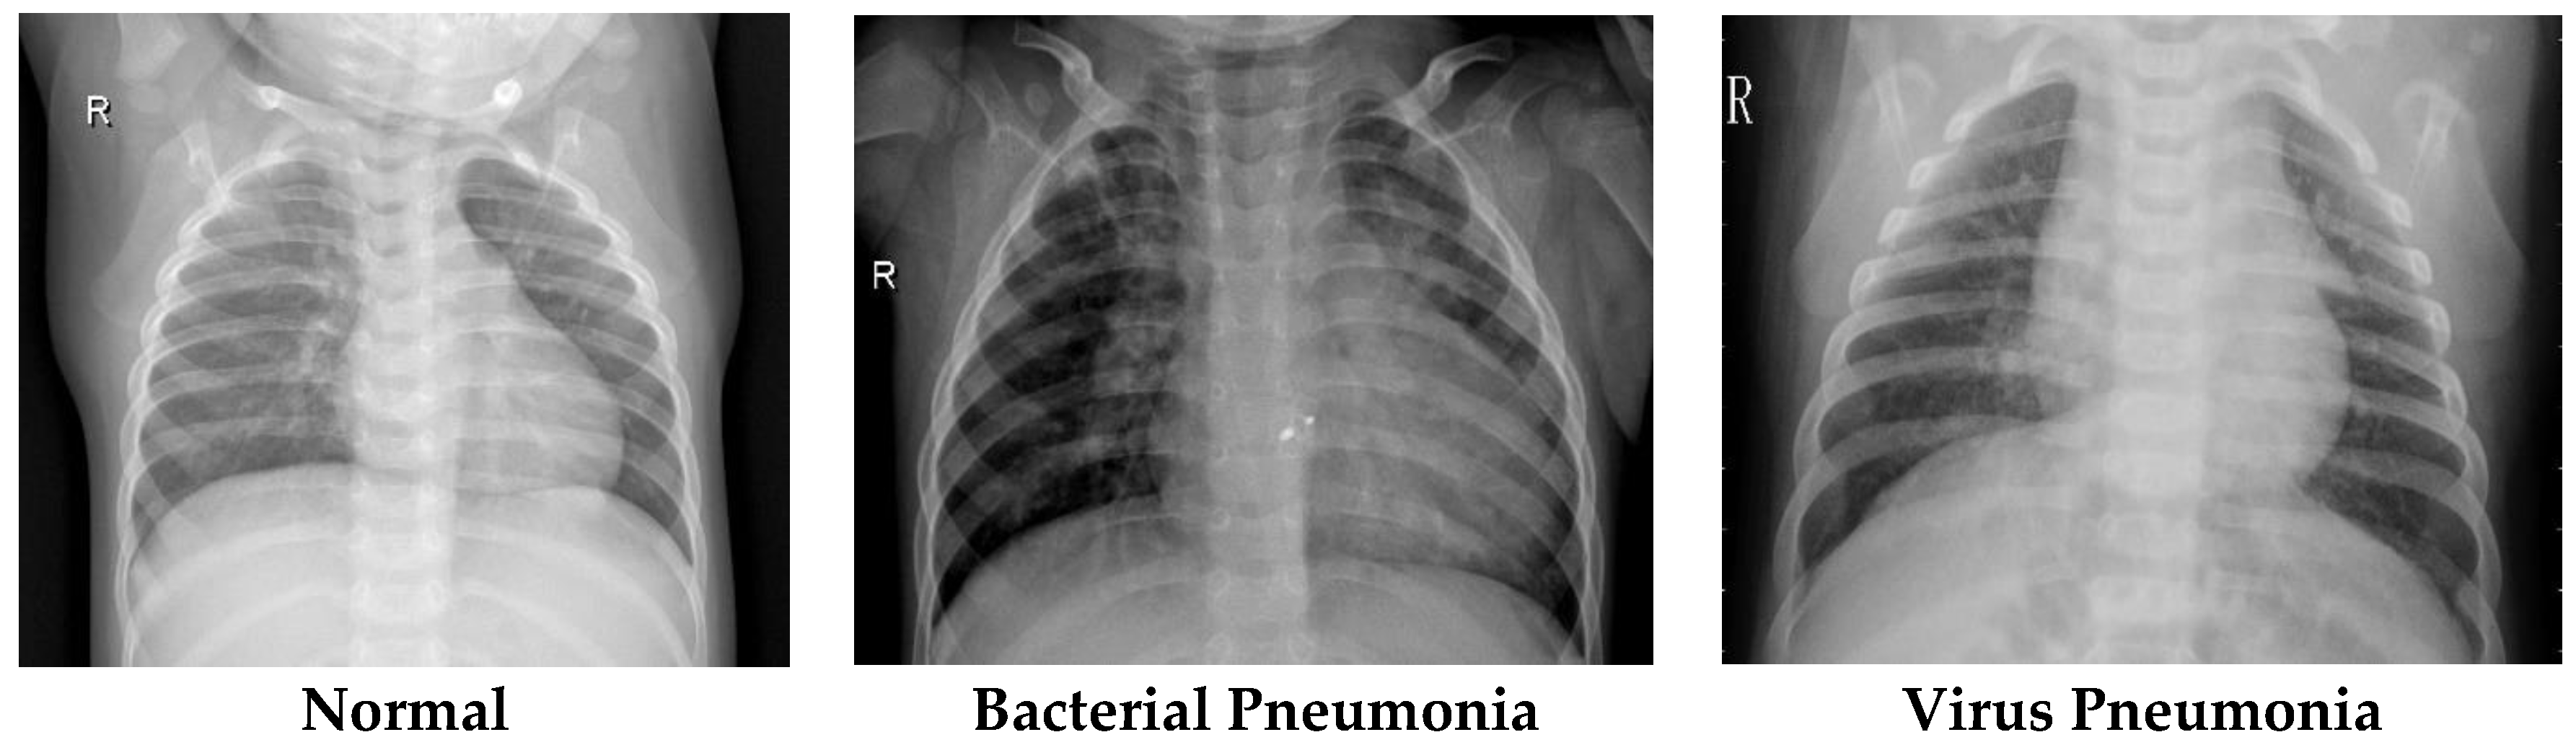

## Problem Statement

Pneumonia is a respiratory disease that causes inflammation in one or both lungs, resulting in symptoms such as cough, fever, and difficulty breathing. Early detection of pneumonia is essential for effective treatment and improved patient outcomes. It accounts for more than 15% of deaths in children under the age of five years. Therefore, early diagnosis and management can play a pivotal role in preventing the disease from becoming fatal.

In acute respiratory diseases, human lungs are made up of small sacs called alveoli, which are normally in the air in healthy individuals. However, in pneumonia, these alveoli get filled with fluid or "pus." One of the major steps in phenomena detection and treatment is obtaining the chest X-ray (CXR). Physicians use this X-ray image to diagnose or monitor treatment for pneumonia conditions. This type of chest X-ray is also used in the diagnosis of diseases like emphysema, lung cancer, line and tube placement, and tuberculosis.

Moreover, there is significant variability in the way chest X-ray images are acquired and processed, which can impact the quality and consistency of the images. This variability can make it challenging to develop robust algorithms that can accurately identify pneumonia in all types of images. Hence, there is a need to develop robust, data-driven algorithms that are trained on large, high-quality datasets and validated using a range of imaging techniques and expert radiological analysis.

## Main Objectives
1.	Research, design, and implement advanced algorithms for the accurate detection of pneumonia in chest X-ray images.
2.	Construct a robust binary classifier capable of distinguishing between normal and pneumonia cases in chest X-ray images.
3.	Integrate the developed pneumonia detection algorithms into an automated diagnostic tool for chest X-ray images.
4.	Improve the efficiency and precision of pneumonia diagnosis by deploying the automated diagnostic tool.


## Specific Objective
The goal of this project is to develop an automated system for detecting and classifying pneumonia in medical images. 
Design and implement a robust deep learning algorithm, for detecting and classifying pneumonia in chest X-ray images.


## Data Understanding


The dataset, sourced from Kaggle and accessible at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data , is organized into three main folders: train, test, and val. Each folder includes subfolders representing two distinct image categories: Pneumonia and Normal. The dataset comprises a total of 5,856 chest X-ray images in JPEG format. These images, employing the anterior-posterior technique, originate from retrospective cohorts of pediatric patients aged one to five years at the Guangzhou Women and Children’s Medical Center in Guangzhou, China. The inclusion of these chest X-ray images in the dataset was part of routine clinical care for pediatric patients.

Ensuring dataset quality, an initial screening process eliminated low-quality or unreadable scans to minimize errors. Two expert physicians then meticulously graded the diagnoses associated with the images, deeming them suitable for training the AI system only after this rigorous evaluation. To further mitigate potential grading errors, an additional layer of scrutiny was applied to the evaluation set. This involved examination by a third expert, providing an extra level of assurance to the accuracy of the diagnoses. This comprehensive approach to quality control and grading establishes a robust foundation for the analysis of chest X-ray images, enhancing the reliability of the AI system trained on this dataset.


### Importing libraries

In [1]:
# Import libraries
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import opendatasets as od

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import random
from pathlib import Path #to be able to use functions using path
from collections import Counter

# Data science tools
import pandas as pd # data processing
import numpy as np # linear algebra

# Tensorflow for GPU
import tensorflow as tf
from tensorflow.compat.v1 import Session, ConfigProto, set_random_seed
from tensorflow.python.client import device_lib

# Keras library for Modeling
import keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.constraints import max_norm
#import tensorflow.contrib.keras as keras
from keras import backend as K

# OpenCV
import cv2

# Resize images
from skimage.io import imread
from skimage.transform import resize

# Scikit-learn library
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Visualizations
from PIL import Image
import imgaug as aug
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mimg # images
%matplotlib inline
import seaborn as sns
import plotly.express as px

### Loading Data

The initial step involves loading the dataset of chest X-ray images, each labelled with annotations indicating the presence of pneumonia or normal conditions. Following this, we standardise the size of all images to ensure uniformity.

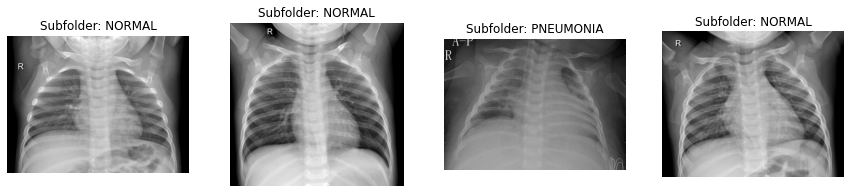

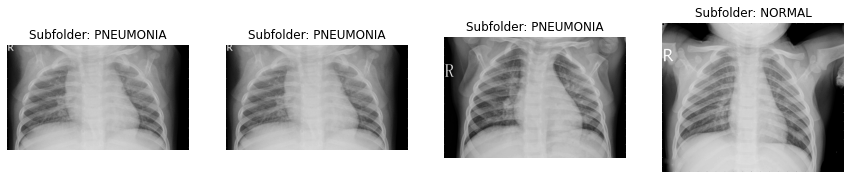

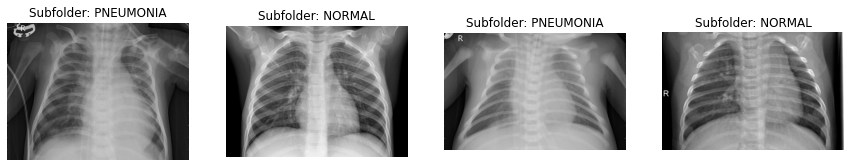

In [7]:
labels = ['PNEUMONIA', 'NORMAL']

# Define the data directories
data_folder = os.path.abspath(r"C:\Users\Mollean\Documents\Moringa\Phase_5\Final\Phase-5-Project\chest_xray\chest_xray")
train_data_folder = os.path.join(data_folder, 'train')
val_data_folder = os.path.join(data_folder, 'val')
test_data_folder = os.path.join(data_folder, 'test')

# Function to load and display a sample of images
def load_and_display_sample_images(folder, sample_size=5):
    fig, axes = plt.subplots(1, sample_size, figsize=(15, 3))

    # Display samples for each subfolder
    subfolders = os.listdir(folder)
    for i in range(sample_size):
        random_subfolder = random.choice(subfolders)
        random_image_index = random.randint(0, len(os.listdir(os.path.join(folder, random_subfolder))) - 1)
        random_image_path = os.path.join(folder, random_subfolder, os.listdir(os.path.join(folder, random_subfolder))[random_image_index])
        sample_image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)

        axes[i].imshow(sample_image, cmap='gray')
        axes[i].set_title(f"Subfolder: {random_subfolder}")
        axes[i].axis('off')

    plt.show()

# Load and display a sample of images for each folder
load_and_display_sample_images(train_data_folder, sample_size=4)
load_and_display_sample_images(val_data_folder, sample_size=4)
load_and_display_sample_images(test_data_folder, sample_size=4)


We then determine the quantity of images in the training, testing and validation sets.

In [8]:
def count_files(folder):
    count = 0
    for root, dirs, files in os.walk(folder):
        count += len(files)
    return count

# Count files in each folder
train_count = count_files(train_data_folder)
val_count = count_files(val_data_folder)
test_count = count_files(test_data_folder)

print(f"Number of files in train folder: {train_count}")
print(f"Number of files in val folder: {val_count}")
print(f"Number of files in test folder: {test_count}")

Number of files in train folder: 5216
Number of files in val folder: 16
Number of files in test folder: 624


We check and print the count of files in the different sub-folders corresponding to the specified labels for the training, validation, and test sets.

In [9]:
def count_files_in_subfolders(folder):
    subfolder_counts = {}
    
    for root, dirs, files in os.walk(folder):
        subfolder_name = os.path.relpath(root, folder)
        subfolder_counts[subfolder_name] = len(files)
    
    return subfolder_counts

# Count files in each subfolder of train folder
train_subfolder_counts = count_files_in_subfolders(train_data_folder)
print("Number of files in each subfolder of train folder:")
for subfolder, count in train_subfolder_counts.items():
    print(f"{subfolder}: {count}")

# Count files in each subfolder of val folder
val_subfolder_counts = count_files_in_subfolders(val_data_folder)
print("\nNumber of files in each subfolder of val folder:")
for subfolder, count in val_subfolder_counts.items():
    print(f"{subfolder}: {count}")

# Count files in each subfolder of test folder
test_subfolder_counts = count_files_in_subfolders(test_data_folder)
print("\nNumber of files in each subfolder of test folder:")
for subfolder, count in test_subfolder_counts.items():
    print(f"{subfolder}: {count}")


Number of files in each subfolder of train folder:
.: 0
NORMAL: 1341
PNEUMONIA: 3875

Number of files in each subfolder of val folder:
.: 0
NORMAL: 8
PNEUMONIA: 8

Number of files in each subfolder of test folder:
.: 0
NORMAL: 234
PNEUMONIA: 390


### Data Inspection

Then we validate for corrupt files: It is crucial to identify and eliminate corrupt images as they can lead to errors during the model training or introduce biases. 


In [10]:
def find_corrupt_files(folder):
    corrupt_files = []

    for root, dirs, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                _ = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            except (cv2.error, Exception):
                corrupt_files.append(file_path)

    return corrupt_files

# Find and print corrupt files in the train folder
corrupt_files_train = find_corrupt_files(train_data_folder)

# Find and print corrupt files in the val folder
corrupt_files_val = find_corrupt_files(val_data_folder)

# Find and print corrupt files in the test folder
corrupt_files_test = find_corrupt_files(test_data_folder)

# Print count of corrupt files in each folder
print(f"Number of corrupt files in train folder: {len(corrupt_files_train)}")
print(f"Number of corrupt files in val folder: {len(corrupt_files_val)}")
print(f"Number of corrupt files in test folder: {len(corrupt_files_test)}")

# Print a statement if no corrupt files are found
if not corrupt_files_train and not corrupt_files_val and not corrupt_files_test:
    print("No corrupt files found.")


Number of corrupt files in train folder: 0
Number of corrupt files in val folder: 0
Number of corrupt files in test folder: 0
No corrupt files found.


The above is further supported by the examination of the datasets by the experts as highlighted under the section on Data Understanding

### Data Cleaning
Detecting whether an image is blurred based on the variance of the Laplacian. This is a common technique to identify blurred images in image processing applications.

In [11]:
def check_image_quality(folder, quality_threshold):
    low_quality_images = []

    for root, dirs, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if cv2.Laplacian(image, cv2.CV_64F).var() < quality_threshold:
                    low_quality_images.append(file_path)
            except (cv2.error, Exception):
                pass

    return low_quality_images

# Set the quality threshold (adjust as needed)
quality_threshold = 100

# Check and print low-quality images in the train folder
low_quality_images_train = check_image_quality(train_data_folder, quality_threshold)
print(f"Low-quality images in train folder: {low_quality_images_train}")

# Check and print low-quality images in the val folder
low_quality_images_val = check_image_quality(val_data_folder, quality_threshold)
print(f"Low-quality images in val folder: {low_quality_images_val}")

# Check and print low-quality images in the test folder
low_quality_images_test = check_image_quality(test_data_folder, quality_threshold)
print(f"Low-quality images in test folder: {low_quality_images_test}")

# Print count of low-quality images in each folder
print(f"Number of low-quality images in train folder: {len(low_quality_images_train)}")
print(f"Number of low-quality images in val folder: {len(low_quality_images_val)}")
print(f"Number of low-quality images in test folder: {len(low_quality_images_test)}")

# Print a statement if no low-quality images are found
if not low_quality_images_train and not low_quality_images_val and not low_quality_images_test:
    print("No low-quality images found.")


Low-quality images in train folder: ['C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\train\\NORMAL\\IM-0115-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\train\\NORMAL\\IM-0117-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\train\\NORMAL\\IM-0119-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\train\\NORMAL\\IM-0122-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\train\\NORMAL\\IM-0154-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\train\\NORMAL\\IM-0172-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\train\\NORMAL\\IM-0177-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\

Low-quality images in val folder: ['C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\val\\NORMAL\\NORMAL2-IM-1442-0001.jpeg']
Low-quality images in test folder: ['C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\test\\NORMAL\\IM-0003-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\test\\NORMAL\\IM-0049-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\test\\NORMAL\\IM-0050-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\test\\NORMAL\\IM-0059-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\test\\NORMAL\\IM-0061-0001.jpeg', 'C:\\Users\\Mollean\\Documents\\Moringa\\Phase_5\\Final\\Phase-5-Project\\chest_xray\\chest_xray\\test\\NORMAL\\IM-0063-0001.jpeg'

* Number of low-quality images in train folder: 1671
* Number of low-quality images in val folder: 1
* Number of low-quality images in test folder: 263

The data output indicates a notable presence of low-quality images. Subsequently, we undertake a detailed examination of specific quality issues to enhance resolution.

In [14]:
def check_blur(image):
    # Use Laplacian variance to measure image blur
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    return laplacian_var

def check_contrast(image):
    # Calculate the image histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    # Calculate the spread of the histogram
    spread = np.sum(hist > 0)
    return spread

def check_noise(image):
    # Use variance of pixel intensity to measure noise
    noise_var = np.var(image)
    return noise_var

def check_resolution(image):
    # Get image dimensions
    height, width = image.shape[:2]
    return height, width

# Load an example image
image_path = r"C:\Users\Mollean\Documents\Moringa\Phase_5\Final\Phase-5-Project\chest_xray\chest_xray\train\PNEUMONIA\person309_virus_632.jpeg"

original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert the image to grayscale for some metrics
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Check for blur
blur_score = check_blur(gray_image)
print("Blur Score:", blur_score)

# Check for contrast
contrast_score = check_contrast(gray_image)
print("Contrast Score:", contrast_score)

# Check for noise
noise_score = check_noise(gray_image)
print("Noise Score:", noise_score)

# Check image resolution
resolution = check_resolution(original_image)
print("Image Resolution:", resolution)

Blur Score: 226.3698964089472
Contrast Score: 250
Noise Score: 3563.320370663648
Image Resolution: (736, 1128)


The output values from the quality checks provide information about certain characteristics of the image:

1. **Blur Score (226.37):** This score is obtained using the Laplacian variance method. Higher values generally indicate more sharpness in the image. In this case, a score of 226.37 is reasonable, suggesting that the image is not excessively blurry.

2. **Contrast Score (250):** This score is based on the spread of the image histogram. A higher contrast score indicates a greater range of pixel intensities, implying good contrast in the image. A score of 250 is relatively high and suggests good contrast.

3. **Noise Score (3563.32):** This score represents the variance of pixel intensity, which is used to measure noise. Higher values can indicate more noise. In this case, 3563.32 is relatively high, suggesting the presence of some noise in the image.

4. **Image Resolution (736, 1128):** The resolution is given by the height and width of the image in pixels. In this case, the image has a resolution of 736 pixels in height and 1128 pixels in width.

In summary:
- The blur and contrast scores seem reasonable and indicate a reasonably sharp and well-contrasted image.
- The noise score is relatively high, suggesting the presence of some noise. Depending on the context and specific requirements, this level of noise may or may not be acceptable.
- The image resolution is 736x1128 pixels, providing information about the size of the image

In [16]:
def check_blur(image):
    # Use Laplacian variance to measure image blur
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    return laplacian_var

def check_contrast(image):
    # Calculate the image histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    # Calculate the spread of the histogram
    spread = np.sum(hist > 0)
    return spread

def check_noise(image):
    # Use variance of pixel intensity to measure noise
    noise_var = np.var(image)
    return noise_var

def check_resolution(image):
    # Get image dimensions
    height, width = image.shape[:2]
    return height, width

# Load an example image
image_path = r"C:\Users\Mollean\Documents\Moringa\Phase_5\Final\Phase-5-Project\chest_xray\chest_xray\train\NORMAL\IM-0235-0001.jpeg"
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert the image to grayscale for some metrics
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Check for blur
blur_score = check_blur(gray_image)
print("Blur Score:", blur_score)

# Check for contrast
contrast_score = check_contrast(gray_image)
print("Contrast Score:", contrast_score)

# Check for noise
noise_score = check_noise(gray_image)
print("Noise Score:", noise_score)

# Check image resolution
resolution = check_resolution(original_image)
print("Image Resolution:", resolution)

Blur Score: 77.90908034383216
Contrast Score: 256
Noise Score: 4093.4453576459046
Image Resolution: (1500, 1816)


Here's an analysis of the quality scores for the provided image:

1. **Blur Score (77.91):** The blur score is relatively low, indicating a less sharper image.Reduced numerical values indicate increased blurriness, a factor that may be undesirable depending on the specific context.

2. **Contrast Score (256):** The contrast score is relatively high, suggesting a good range of pixel intensities and strong contrast in the image. A higher contrast score is generally considered favorable.

3. **Noise Score (4093.45):** The noise score is relatively high, indicating the presence of some noise in the image. Depending on the application, this level of noise may or may not be acceptable.

4. **Image Resolution (1500x1816):** The image has a resolution of 1500 pixels in height and 1816 pixels in width. This provides information about the size of the image.

In summary:
- The image exhibits a lack of sharpness, correlating with a low blur score.
- It has strong contrast, as indicated by the high contrast score.
- There is some level of noise present, as suggested by the noise score.
- The resolution is 1500x1816 pixels, indicating a moderately high-resolution image.

Upon reviewing the outcomes for the two images, it is evident that the primary concerns pertain to image size, noise, and blurriness. To address these issues, we intend to standardize the image resolution and subsequently minimize both noise and blurriness.

###### Image Quality Threshold
There is no one size fits all solution and for our model we adjusted these thresholds based on the requirements of our image classification task.
1. Blur score: A blur score below 100 indicates significant blurring.
2. Contrast score: A contrast score below 100 suggests low contrast.
3. Noise score: A noise score above 1000 may indicate a noisy image.
4. Resolution threshold:Medical imaging applications require higher standards for image quality.


### Data Preparation & Pre-processing:

Data augmentation techniques serve the purpose of artificially increasing the diversity of a dataset by applying various transformations to the existing data. In the context of image data, augmentation involves creating new images by making slight modifications to the original ones. The primary purposes of augmentation techniques are: increased diversity, improved robustness, reduced over-fitting, better generalisations and enhanced training efficiency.

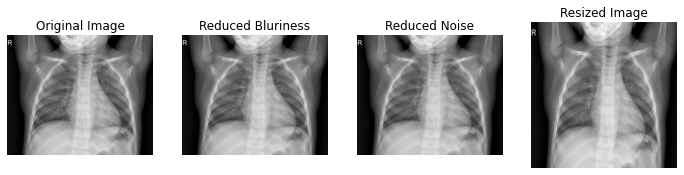

In [18]:
# Function to reduce bluriness
def reduce_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Function to reduce noise
def reduce_noise(image):
    return cv2.fastNlMeansDenoising(image, None, h=10, searchWindowSize=21, templateWindowSize=7)

# Function to resize images
def resize_image(image, target_size=(224, 224)):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

# Load an example image
image_path = r"C:\Users\Mollean\Documents\Moringa\Phase_5\Final\Phase-5-Project\chest_xray\chest_xray\train\NORMAL\IM-0235-0001.jpeg"
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert the image to grayscale for processing
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Reduce bluriness
blurred_image = reduce_blur(gray_image)

# Reduce noise
denoised_image = reduce_noise(blurred_image)

# Resize image
resized_image = resize_image(denoised_image)

# Display the original and processed images
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title('Reduced Bluriness')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(denoised_image, cmap='gray')
plt.title('Reduced Noise')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(resized_image, cmap='gray')
plt.title('Resized Image')
plt.axis('off')

plt.show()

# EDA

In [21]:
# Specify the path to the dataset
data_path = r"C:\Users\Mollean\Documents\Moringa\Phase_5\Final\Phase-5-Project\chest_xray\chest_xray"

# Create lists to store file paths and labels
file_paths = []
labels = []

# Iterate through the dataset and collect file paths and labels
for label in ['NORMAL', 'PNEUMONIA']:
    folder_path = os.path.join(data_path, 'train', label)
    file_paths.extend([os.path.join(folder_path, file) for file in os.listdir(folder_path)])
    labels.extend([label] * len(os.listdir(folder_path)))

# Create a DataFrame
df = pd.DataFrame({'File Path': file_paths, 'Label': labels})

df

,File Path,Label
0,C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...,NORMAL
1,C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...,NORMAL
2,C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...,NORMAL
3,C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...,NORMAL
4,C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...,NORMAL
...,...,...
5211,C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...,PNEUMONIA
5212,C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...,PNEUMONIA
5213,C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...,PNEUMONIA
5214,C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...,PNEUMONIA


### Basic Statistics

In [22]:
# Display basic statistics
print(df.head())
print(df.info())
print(df['Label'].value_counts())

                                           File Path   Label
0  C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...  NORMAL
1  C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...  NORMAL
2  C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...  NORMAL
3  C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...  NORMAL
4  C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...  NORMAL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Path  5216 non-null   object
 1   Label      5216 non-null   object
dtypes: object(2)
memory usage: 81.6+ KB
None
PNEUMONIA    3875
NORMAL       1341
Name: Label, dtype: int64


### Class Distribution Visualization

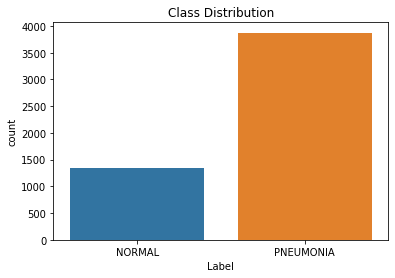

In [23]:
# Visualize class distribution
sns.countplot(x='Label', data=df)
plt.title('Class Distribution')
plt.show()

### Display Sample Images

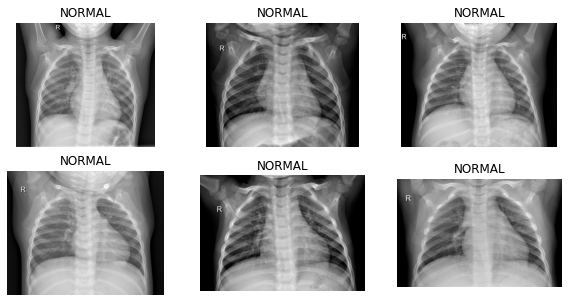

In [24]:
# Display sample images
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    img = Image.open(df['File Path'][i])
    plt.imshow(img, cmap='gray')
    plt.title(df['Label'][i])
    plt.axis('off')
plt.show()

### Image Dimensions

In [26]:
# Get image dimensions
valid_dimensions = []
invalid_files = []

for file_path in df['File Path']:
    try:
        img = Image.open(file_path)
        dimensions = np.array(img).shape
        valid_dimensions.append(dimensions)
    except (OSError, UnidentifiedImageError):
        invalid_files.append(file_path)

# Create a new DataFrame with valid dimensions
valid_df = df[df['File Path'].isin(df['File Path'][~df['File Path'].isin(invalid_files)])]
valid_df['Dimensions'] = valid_dimensions

# Print the dimensions
print(valid_df['Dimensions'].value_counts())

(648, 1072)     7
(728, 1080)     6
(704, 1008)     5
(592, 992)      5
(872, 1216)     5
               ..
(664, 1176)     1
(1279, 1746)    1
(664, 1008)     1
(944, 1592)     1
(1612, 1774)    1
Name: Dimensions, Length: 4366, dtype: int64


In [27]:
print(valid_df['Dimensions'].value_counts().unique())

[7 6 5 4 3 2 1]


### Distribution of Image Dimensions Histogram 

In [28]:
# Split 'Dimensions' into 'Height' and 'Width'
valid_df[['Height', 'Width']] = pd.DataFrame(valid_df['Dimensions'].tolist(), index=valid_df.index)

# Plot the distribution of image height
plt.figure(figsize=(12, 6))
sns.histplot(data=valid_df, x='Height', kde=True)
plt.title('Distribution of Image Height')
plt.xlabel('Image Height')
plt.show()

# Plot the distribution of image width
plt.figure(figsize=(12, 6))
sns.histplot(data=valid_df, x='Width', kde=True)
plt.title('Distribution of Image Width')
plt.xlabel('Image Width')
plt.show()


#  The datatype of the 'Dimensions' column might contain tuples representing the height and width of each image. Seaborn's histplot expects a numeric or categorical variable for
 # the x parameter. Therefore, we separate columns for 'Height' and 'Width' in our DataFrame and then plot them individually. 

ValueError: Columns must be same length as key

In [29]:
# Print the shape of the DataFrame you're trying to assign
print(pd.DataFrame(valid_df['Dimensions'].tolist(), index=valid_df.index).shape)
# Print unique values in 'Dimensions' column
print(valid_df['Dimensions'].unique())


(5216, 3)
[(1858, 2090) (1152, 1422) (1434, 1810) ... (1096, 1232) (882, 1414)
 (728, 1248)]


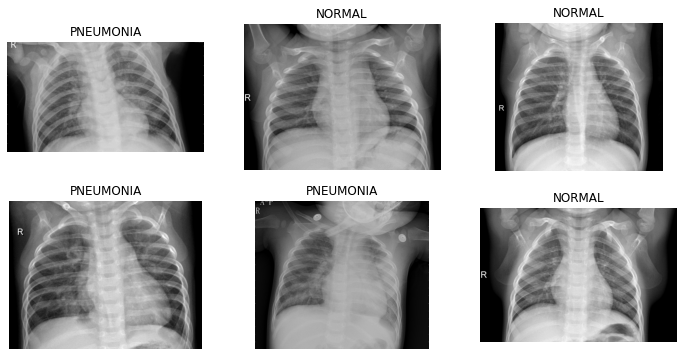

In [30]:
import random

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    random_sample = valid_df.sample(1)
    img = Image.open(random_sample['File Path'].values[0])
    plt.imshow(img, cmap='gray')
    plt.title(random_sample['Label'].values[0])
    plt.axis('off')

plt.show()

### Image Quality Assessment

In [31]:
# Lists to store quality metrics
blur_scores = []
contrast_scores = []
noise_scores = []
resolutions = []

# Iterate through the DataFrame and calculate quality metrics
for file_path in valid_df['File Path']:
    try:
        # Load the image
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Check blur
        blur_score = check_blur(image)
        blur_scores.append(blur_score)

        # Check contrast
        contrast_score = check_contrast(image)
        contrast_scores.append(contrast_score)

        # Check noise
        noise_score = check_noise(image)
        noise_scores.append(noise_score)

        # Check resolution
        resolution = check_resolution(image)
        resolutions.append(resolution)
    except (cv2.error, Exception):
        # Handle exceptions if image loading fails
        blur_scores.append(np.nan)
        contrast_scores.append(np.nan)
        noise_scores.append(np.nan)
        resolutions.append((np.nan, np.nan))

# Add quality metrics to the DataFrame
valid_df['Blur Score'] = blur_scores
valid_df['Contrast Score'] = contrast_scores
valid_df['Noise Score'] = noise_scores
valid_df[['Resolution Height', 'Resolution Width']] = pd.DataFrame(resolutions, index=valid_df.index)

# Display the DataFrame with quality metrics
print(valid_df[['File Path', 'Blur Score', 'Contrast Score', 'Noise Score', 'Resolution Height', 'Resolution Width']])


                                              File Path  Blur Score  \
0     C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...   72.224400   
1     C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...   97.994290   
2     C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...   90.731133   
3     C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...   80.234756   
4     C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...  112.328822   
...                                                 ...         ...   
5211  C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...   72.548726   
5212  C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...  109.687666   
5213  C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...  108.095648   
5214  C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...   99.613863   
5215  C:\Users\Mollean\Documents\Moringa\Phase_5\Fin...  113.108359   

      Contrast Score  Noise Score  Resolution Height  Resolution Width  
0                256  3881.418383               1858              2090  
1

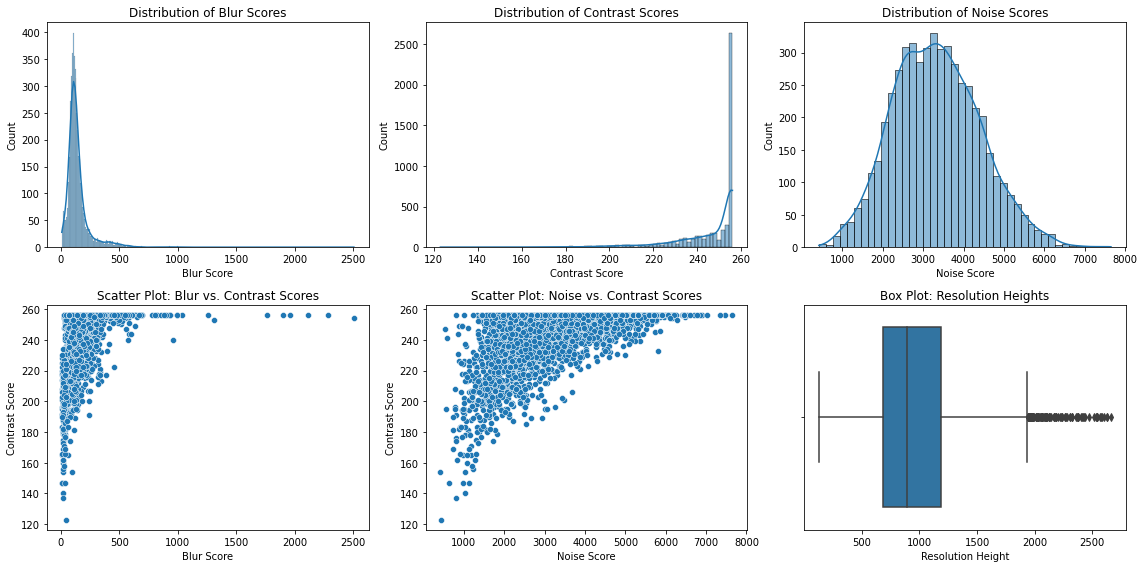

In [32]:
# Analyze and visualize image quality metrics
plt.figure(figsize=(16, 8))

# Subplot 1: Distribution of Blur Scores
plt.subplot(2, 3, 1)
sns.histplot(valid_df['Blur Score'], kde=True)
plt.title('Distribution of Blur Scores')

# Subplot 2: Distribution of Contrast Scores
plt.subplot(2, 3, 2)
sns.histplot(valid_df['Contrast Score'], kde=True)
plt.title('Distribution of Contrast Scores')

# Subplot 3: Distribution of Noise Scores
plt.subplot(2, 3, 3)
sns.histplot(valid_df['Noise Score'], kde=True)
plt.title('Distribution of Noise Scores')

# Subplot 4: Scatter plot of Blur vs. Contrast Scores
plt.subplot(2, 3, 4)
sns.scatterplot(x='Blur Score', y='Contrast Score', data=valid_df)
plt.title('Scatter Plot: Blur vs. Contrast Scores')

# Subplot 5: Scatter plot of Noise vs. Contrast Scores
plt.subplot(2, 3, 5)
sns.scatterplot(x='Noise Score', y='Contrast Score', data=valid_df)
plt.title('Scatter Plot: Noise vs. Contrast Scores')

# Subplot 6: Box plot of Resolution Heights
plt.subplot(2, 3, 6)
sns.boxplot(x='Resolution Height', data=valid_df)
plt.title('Box Plot: Resolution Heights')

plt.tight_layout()
plt.show()


### Pixel Intensity 

In [33]:
# # Pixel Intensity Histogram:
# plt.figure(figsize=(12, 6))
# for label in ['NORMAL', 'PNEUMONIA']:
#     subset = valid_df[valid_df['Label'] == label]
#     intensities = [np.array(Image.open(file)).flatten() for file in subset['File Path']]
#     plt.hist(intensities, bins=50, alpha=0.5, label=label)

# plt.title('Pixel Intensity Distribution')
# plt.xlabel('Pixel Intensity')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

### Outlier Detection:

 1. Image Dimensions Outliers:

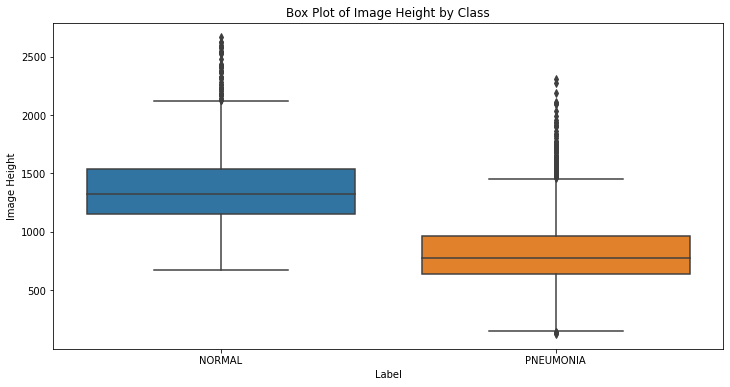

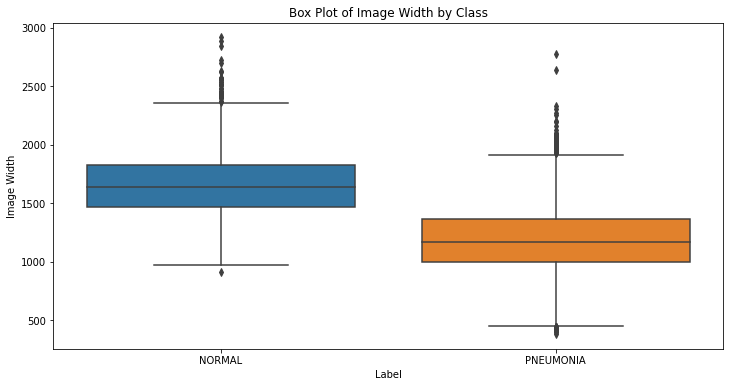

In [34]:
# Check for images with unusual dimensions, which may indicate errors or outliers.
# Calculate image dimensions and add to DataFrame

valid_df['Image Height'] = valid_df['File Path'].apply(lambda x: np.array(Image.open(x)).shape[0])
valid_df['Image Width'] = valid_df['File Path'].apply(lambda x: np.array(Image.open(x)).shape[1])

# Box plots for image height and width
plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Image Height', data=valid_df)
plt.title('Box Plot of Image Height by Class')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Image Width', data=valid_df)
plt.title('Box Plot of Image Width by Class')
plt.show()

2. Pixel Intensity Outliers:

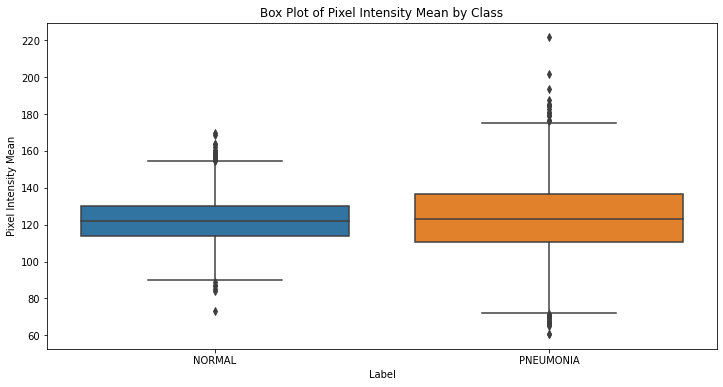

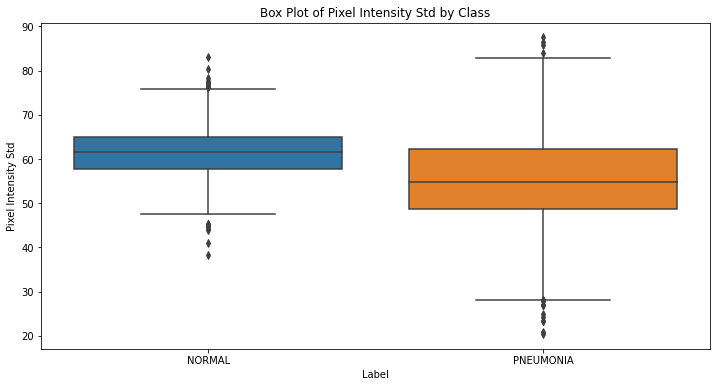

In [35]:
# Calculate pixel intensity statistics
valid_df['Pixel Intensity Mean'] = valid_df['File Path'].apply(lambda x: np.mean(np.array(Image.open(x))))
valid_df['Pixel Intensity Std'] = valid_df['File Path'].apply(lambda x: np.std(np.array(Image.open(x))))

# Box plots for pixel intensity mean and standard deviation
plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Pixel Intensity Mean', data=valid_df)
plt.title('Box Plot of Pixel Intensity Mean by Class')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Pixel Intensity Std', data=valid_df)
plt.title('Box Plot of Pixel Intensity Std by Class')
plt.show()


3. Image Quality Outliers:

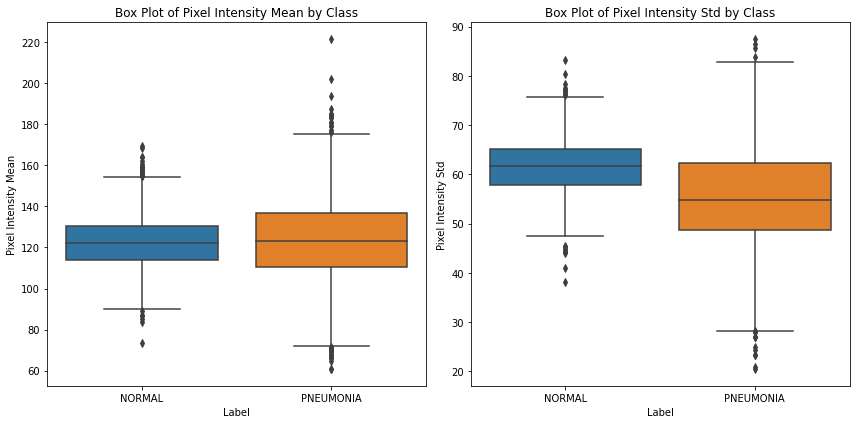

In [36]:
# Function to calculate pixel intensity statistics
def calculate_pixel_intensity_stats(image_path):
    image_array = np.array(Image.open(image_path))
    intensity_mean = np.mean(image_array)
    intensity_std = np.std(image_array)
    return intensity_mean, intensity_std

# Apply the pixel intensity statistics to all images in the DataFrame
valid_df[['Pixel Intensity Mean', 'Pixel Intensity Std']] = valid_df['File Path'].apply(lambda x: pd.Series(calculate_pixel_intensity_stats(x)))

# Box plots for pixel intensity mean and standard deviation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Label', y='Pixel Intensity Mean', data=valid_df)
plt.title('Box Plot of Pixel Intensity Mean by Class')

plt.subplot(1, 2, 2)
sns.boxplot(x='Label', y='Pixel Intensity Std', data=valid_df)
plt.title('Box Plot of Pixel Intensity Std by Class')

plt.tight_layout()
plt.show()


### MODELLING

### Creating a Weighted Loss Function To Address Class Imbalance

We address the issue of class imbalance in a binary image classification task using TensorFlow and Keras. 
The goal is to create a weighted loss function that assigns different weights to classes based on their frequencies in the training data.

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

# Specify the path to the training data
train_data_dir = r"C:\Users\Mollean\Documents\Moringa\Phase_5\Final\Phase-5-Project\chest_xray\chest_xray\train"

# Set up the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)

# Create the training generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='binary',  
    subset='training'  
)

Found 4173 images belonging to 2 classes.


In [82]:
# Get the value counts for each class in the training set
train_value_counts = Counter(train_generator.classes)

# Calculate the number of pneumonia and normal images
num_pneumonia = train_value_counts[1]
num_normal = train_value_counts[0]

# Class weights
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


### CNN

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D

# Create a Sequential model
model = Sequential()

# Add a convolutional layer with 32 filters, kernel size of (3, 3), and input shape of (224, 224, 3)
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu'))

# Add a max pooling layer with pool size of (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer with 64 filters and kernel size of (3, 3)
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Add another max pooling layer with pool size of (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Replace Flatten layer with GlobalAveragePooling2D
model.add(GlobalAveragePooling2D())

# Add a fully connected layer with 128 units and ReLU activation
model.add(Dense(units=128, activation='relu'))

# Add the output layer with 1 unit (assuming binary classification) and sigmoid activation
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_1   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                      

### Training the Model

In [85]:
# Training
r = model.fit(
    train_generator,
    epochs=10,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_data=validation_generator,  
    validation_steps=50  
)

Epoch 1/10
100/100 [==============================] - 237s 2s/step - loss: 0.2654 - accuracy: 0.4929 - val_loss: 0.7039 - val_accuracy: 0.2713
Epoch 2/10
100/100 [==============================] - 184s 2s/step - loss: 0.2505 - accuracy: 0.6561
Epoch 3/10
100/100 [==============================] - 144s 1s/step - loss: 0.2284 - accuracy: 0.7045
Epoch 4/10
100/100 [==============================] - 140s 1s/step - loss: 0.2181 - accuracy: 0.6910
Epoch 5/10
100/100 [==============================] - 136s 1s/step - loss: 0.2070 - accuracy: 0.7403
Epoch 6/10
100/100 [==============================] - 131s 1s/step - loss: 0.1906 - accuracy: 0.7588
Epoch 7/10
100/100 [==============================] - 131s 1s/step - loss: 0.1741 - accuracy: 0.7906
Epoch 8/10
100/100 [==============================] - 133s 1s/step - loss: 0.1677 - accuracy: 0.7979
Epoch 9/10
100/100 [==============================] - 133s 1s/step - loss: 0.1615 - accuracy: 0.8070
Epoch 10/10
100/100 [============================

Text(0.5, 1.0, 'Accuracy Evolution')

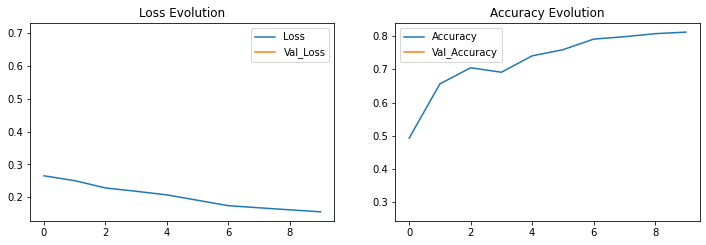

In [86]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [88]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

20/20 [==============================] - 17s 868ms/step - loss: 0.5901 - accuracy: 0.7067
Test Accuracy: 70.67%
131/131 [==============================] - 101s 769ms/step - loss: 0.3398 - accuracy: 0.8478
Train Accuracy: 84.78%


In [94]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test generator
test_evaluation = model.evaluate(test_generator)

# Predict using the model on the test generator
pred = model.predict(test_generator)

# Obtain confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, pred > 0.5)
print("Confusion Matrix:")
print(conf_matrix)

# Obtain classification report
class_report = classification_report(test_generator.classes, pred > 0.5)
print("Classification Report:")
print(class_report)

20/20 [==============================] - 6s 308ms/step - loss: 0.5901 - accuracy: 0.7067
Confusion Matrix:
[[ 61 173]
 [112 278]]
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.26      0.30       234
           1       0.62      0.71      0.66       390

    accuracy                           0.54       624
   macro avg       0.48      0.49      0.48       624
weighted avg       0.52      0.54      0.53       624



In [95]:
import pandas as pd

# Obtain classification report
class_report = classification_report(test_generator.classes, pred > 0.5)
print("Classification Report:")
print(class_report)

# Create a DataFrame from the classification report
df_class_report = pd.DataFrame(classification_report(test_generator.classes, pred > 0.7, output_dict=True))
print("DataFrame Classification Report:")
print(df_class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.26      0.30       234
           1       0.62      0.71      0.66       390

    accuracy                           0.54       624
   macro avg       0.48      0.49      0.48       624
weighted avg       0.52      0.54      0.53       624

DataFrame Classification Report:
                    0           1  accuracy   macro avg  weighted avg
precision    0.353741    0.606061  0.487179    0.479901      0.511441
recall       0.444444    0.512821  0.487179    0.478632      0.487179
f1-score     0.393939    0.555556  0.487179    0.474747      0.494949
support    234.000000  390.000000  0.487179  624.000000    624.000000


### DenseNet

In [99]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121  # Correct import statement

# Define input shape and number of classes
input_shape = (150, 150, 3)  # Adjust the dimensions based on your image size and channels
num_classes = 2  # Pneumonia and Normal

# Load DenseNet121 model pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Create a sequential model
model = Sequential()

# Add the pre-trained base model
model.add(base_model)

# Add additional layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

29097984/29084464 [==============================] - 6s 0us/step


C:\Users\Mollean\anaconda3\envs\learn-env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [100]:
# Display model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten_8 (Flatten)         (None, 16384)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               4194560   
                                                                 
 batch_normalization_12 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 2)                 514       
                                                                 
Total params: 11,233,602
Trainable params: 11,149,442
Non-trainable params: 84,160
____________________________________

In [101]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 427 layers


In [102]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [103]:
#model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [105]:
r = model.fit(
    train_generator,  
    epochs=10,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_data=validation_generator,  
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 1810s 17s/step - loss: 0.0796 - accuracy: 0.9173 - val_loss: 10.3900 - val_accuracy: 0.2905
Epoch 2/10
100/100 [==============================] - 1535s 15s/step - loss: 0.0532 - accuracy: 0.9519
Epoch 3/10
100/100 [==============================] - 1634s 16s/step - loss: 0.0488 - accuracy: 0.9478
Epoch 4/10
100/100 [==============================] - 1556s 16s/step - loss: 0.0485 - accuracy: 0.9525
Epoch 5/10
100/100 [==============================] - 1440s 14s/step - loss: 0.0446 - accuracy: 0.9554
Epoch 6/10
100/100 [==============================] - 1456s 15s/step - loss: 0.0421 - accuracy: 0.9585
Epoch 7/10
100/100 [==============================] - 4718s 47s/step - loss: 0.0389 - accuracy: 0.9566
Epoch 8/10
100/100 [==============================] - 3352s 33s/step - loss: 0.0400 - accuracy: 0.9588
Epoch 9/10
100/100 [==============================] - 1536s 15s/step - loss: 0.0330 - accuracy: 0.9663
Epoch 10/10
100/100 [=========

Text(0.5, 1.0, 'Accuracy Evolution')

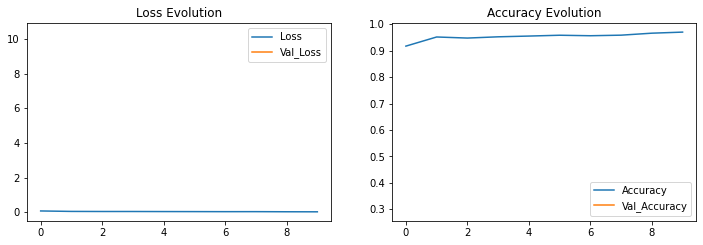

In [106]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [108]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

20/20 [==============================] - 35s 2s/step - loss: 0.7217 - accuracy: 0.7564
Test Accuracy: 75.64%
131/131 [==============================] - 382s 3s/step - loss: 0.1757 - accuracy: 0.9300
Train Accuracy: 93.00%


### DenseNet Evaluation

In [110]:
test_data_dir = r"C:\Users\Mollean\Documents\Moringa\Phase_5\Final\Phase-5-Project\chest_xray\chest_xray\test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Set shuffle to False to ensure the order of predictions matches the order of your files
)

# Now you can use the model to predict on the test data
predicted_vals = model.predict(test_generator, steps=len(test_generator))

Found 624 images belonging to 2 classes.


In [112]:
print(confusion_matrix(test_generator.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test_generator.classes, predicted_vals > 0.5, output_dict=True))

[[224  10]
 [ 68 322]]


,0,1,accuracy,macro avg,weighted avg
precision,0.767123,0.969880,0.875,0.868501,0.893846
recall,0.957265,0.825641,0.875,0.891453,0.875000
f1-score,0.851711,0.891967,0.875,0.871839,0.876871
support,234.000000,390.000000,0.875,624.000000,624.000000


In [142]:
tf.keras.models.save_model(model,'xray_model.hdf5')

### InceptioNet

In [120]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

# Specify the path to the training data
train_data_dir = r"C:\Users\Mollean\Documents\Moringa\Phase_5\Final\Phase-5-Project\chest_xray\chest_xray\train"

# Set up the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create the training generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  
    subset='training'
)

# Get the value counts for each class in the training set
train_value_counts = Counter(train_generator.classes)

# Calculate the number of pneumonia and normal images
num_pneumonia = train_value_counts[1]
num_normal = train_value_counts[0]

# Class weights
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

# Load InceptionV3 model pre-trained on ImageNet
base_model_incep = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Create a sequential model
model_incep = Sequential()

# Add the pre-trained base model
model_incep.add(base_model_incep)

# Replace the AveragePooling2D layer with GlobalAveragePooling2D
model_incep.add(GlobalAveragePooling2D())

# Add additional layers
model_incep.add(Dense(256, activation='relu'))
model_incep.add(BatchNormalization())
model_incep.add(Dense(1, activation='sigmoid'))  # Updated to have one unit and sigmoid activation

# Compile the model
model_incep.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Found 4173 images belonging to 2 classes.
Weight for class 0: 0.74
Weight for class 1: 0.26


In [121]:
# Display model summary
model_incep.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_27 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_391 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dense_28 (Dense)            (None, 1)                 257       
                                                                 
Total params: 22,328,609
Trainable params: 22,293,665

In [122]:
# Training the model
r_incep = model_incep.fit(
    train_generator,
    epochs=10,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 1885s 19s/step - loss: 0.0974 - accuracy: 0.8869 - val_loss: 0.2886 - val_accuracy: 0.8965
Epoch 2/10
100/100 [==============================] - 808s 8s/step - loss: 0.0536 - accuracy: 0.9506
Epoch 3/10
100/100 [==============================] - 771s 8s/step - loss: 0.0376 - accuracy: 0.9706
Epoch 4/10
100/100 [==============================] - 753s 8s/step - loss: 0.0308 - accuracy: 0.9739
Epoch 5/10
100/100 [==============================] - 740s 7s/step - loss: 0.0322 - accuracy: 0.9723
Epoch 6/10
100/100 [==============================] - 731s 7s/step - loss: 0.0278 - accuracy: 0.9727
Epoch 7/10
100/100 [==============================] - 745s 7s/step - loss: 0.0280 - accuracy: 0.9734
Epoch 8/10
100/100 [==============================] - 744s 7s/step - loss: 0.0210 - accuracy: 0.9808
Epoch 9/10
100/100 [==============================] - 747s 7s/step - loss: 0.0180 - accuracy: 0.9830
Epoch 10/10
100/100 [==========================

Text(0.5, 1.0, 'Accuracy Evolution')

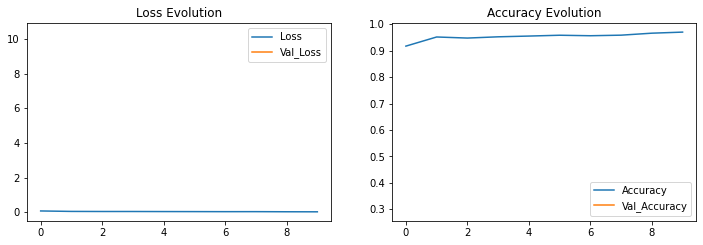

In [123]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [125]:
evaluation = model_incep.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_incep.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

20/20 [==============================] - 42s 2s/step - loss: 0.3007 - accuracy: 0.8958
Test Accuracy: 89.58%
131/131 [==============================] - 321s 2s/step - loss: 0.0216 - accuracy: 0.9938
Train Accuracy: 99.38%


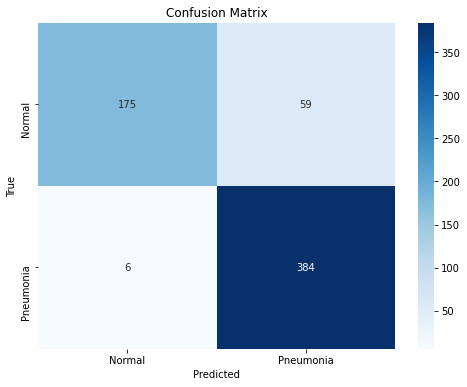

              precision    recall  f1-score   support

      Normal       0.97      0.75      0.84       234
   Pneumonia       0.87      0.98      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.88       624
weighted avg       0.90      0.90      0.89       624



In [127]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Make predictions on the test set
test_generator.reset()
y_pred = model_incep.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Extract true labels
y_true = test_generator.classes

# Define class names
class_names = ['Normal', 'Pneumonia']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, class_names)

# Display classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

### Comparing The Models

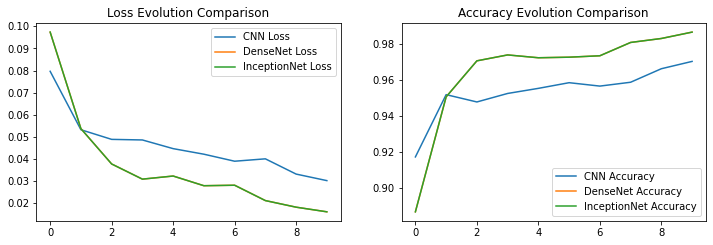

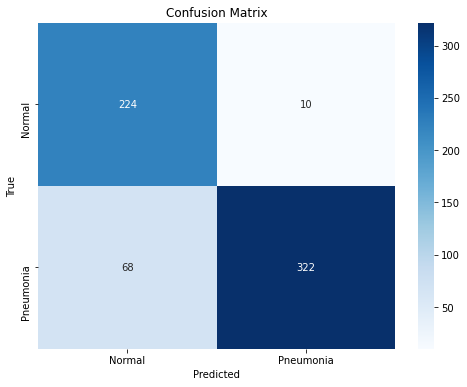

model Classification Report:
              precision    recall  f1-score   support

      Normal       0.77      0.96      0.85       234
   Pneumonia       0.97      0.83      0.89       390

    accuracy                           0.88       624
   macro avg       0.87      0.89      0.87       624
weighted avg       0.89      0.88      0.88       624



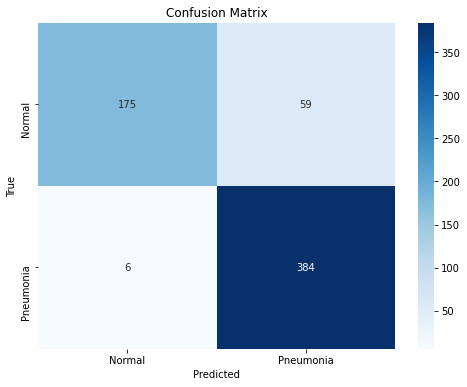

sequential_14 Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.75      0.84       234
   Pneumonia       0.87      0.98      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.88       624
weighted avg       0.90      0.90      0.89       624



In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val_Loss')
    plt.legend()
    plt.title(f'{model_name} Loss Evolution')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
    plt.legend()
    plt.title(f'{model_name} Accuracy Evolution')

# Function to evaluate and plot confusion matrix
def evaluate_and_plot_confusion_matrix(model, test_generator, class_names, threshold=0.5):
    # Make predictions on the test set
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > threshold).astype(int)  # Convert probabilities to binary predictions
    
    # Extract true labels
    y_true = test_generator.classes
    
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred_classes, class_names)
    
    # Display classification report
    print(f'{model.name} Classification Report:')
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Comparison of Loss and Accuracy Evolution
plt.figure(figsize=(12, 8))

# Plot Loss Evolution
plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='CNN Loss')
plt.plot(r_incep.history['loss'], label='DenseNet Loss')
plt.plot(r_incep.history['loss'], label='InceptionNet Loss')
plt.legend()
plt.title('Loss Evolution Comparison')

# Plot Accuracy Evolution
plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='CNN Accuracy')
plt.plot(r_incep.history['accuracy'], label='DenseNet Accuracy')
plt.plot(r_incep.history['accuracy'], label='InceptionNet Accuracy')
plt.legend()
plt.title('Accuracy Evolution Comparison')

# Evaluation and Confusion Matrix for each model
evaluate_and_plot_confusion_matrix(model, test_generator, class_names, threshold=0.5)
evaluate_and_plot_confusion_matrix(model_incep, test_generator, class_names, threshold=0.5)

plt.show()